<a href="https://colab.research.google.com/github/Aurora-Fund-Analytics/forecast-model/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Model

In [ ]:
!pip install yfinance torch numpy pandas scikit-learn matplotlib

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Download & Preprocess Stock Data

In [18]:
# -------------------
# 1. Load Stock Data
# -------------------
ticker = "E1VFVN30.VN"
df = yf.download(ticker, start="2015-01-01", end="2024-12-31")
# Use OHLCV features (Open, High, Low, Close, Volume)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].values

/tmp/ipython-input-298026044.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [19]:
# Normalize data (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [20]:
# -------------------
# 2. Create Dataset
# -------------------
SEQ_LEN = 60  # lookback window (60 days)

class StockDataset(Dataset):
    def __init__(self, data, seq_len=SEQ_LEN):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq_x = self.data[idx:idx + self.seq_len]       # shape: (seq_len, num_features)
        seq_y = self.data[idx + self.seq_len, 3]        # predict "Close" price (index=3)
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

In [21]:
dataset = StockDataset(scaled_data, SEQ_LEN)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset = torch.utils.data.Subset(dataset, range(train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Building LSTM model and training

In [22]:
# -------------------
# 3. Build model
# -------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)              # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]                # last timestep
        out = self.fc(out)                 # (batch, 1)
        return out.squeeze()               # (batch,)

input_size = len(features)  # 5 (OHLCV)
model = LSTMModel(input_size=input_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for seq, target in train_loader:
        optimizer.zero_grad()
        output = model(seq)            # seq: (batch, seq_len, input_size)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {total_loss/len(train_loader):.6f}")

Epoch 1/30, Train Loss: 0.337524
Epoch 2/30, Train Loss: 0.213743
Epoch 3/30, Train Loss: 0.092923
Epoch 4/30, Train Loss: 0.022036
Epoch 5/30, Train Loss: 0.069870
Epoch 6/30, Train Loss: 0.053738
Epoch 7/30, Train Loss: 0.046456
Epoch 8/30, Train Loss: 0.041750
Epoch 9/30, Train Loss: 0.031860
Epoch 10/30, Train Loss: 0.025668
Epoch 11/30, Train Loss: 0.027723
Epoch 12/30, Train Loss: 0.026628
Epoch 13/30, Train Loss: 0.023709
Epoch 14/30, Train Loss: 0.018932
Epoch 15/30, Train Loss: 0.014781
Epoch 16/30, Train Loss: 0.013132
Epoch 17/30, Train Loss: 0.011281
Epoch 18/30, Train Loss: 0.009743
Epoch 19/30, Train Loss: 0.007814
Epoch 20/30, Train Loss: 0.007272
Epoch 21/30, Train Loss: 0.007542
Epoch 22/30, Train Loss: 0.007082
Epoch 23/30, Train Loss: 0.007262
Epoch 24/30, Train Loss: 0.007816
Epoch 25/30, Train Loss: 0.007455
Epoch 26/30, Train Loss: 0.007662
Epoch 27/30, Train Loss: 0.005893
Epoch 28/30, Train Loss: 0.006127
Epoch 29/30, Train Loss: 0.007103
Epoch 30/30, Train Loss

# Evaluate & Plot Predictions

In [24]:
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for seq, target in test_loader:
        output = model(seq)
        preds.extend(output.numpy())
        actuals.extend(target.numpy())

# Inverse transform: need to reconstruct full feature vector with predicted Close
preds = np.array(preds).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

# Fill dummy values for OHLCV to inverse only Close
dummy = np.zeros((len(preds), len(features)))
dummy[:, 3] = preds[:, 0]
preds_rescaled = scaler.inverse_transform(dummy)[:, 3]

dummy = np.zeros((len(actuals), len(features)))
dummy[:, 3] = actuals[:, 0]
actuals_rescaled = scaler.inverse_transform(dummy)[:, 3]

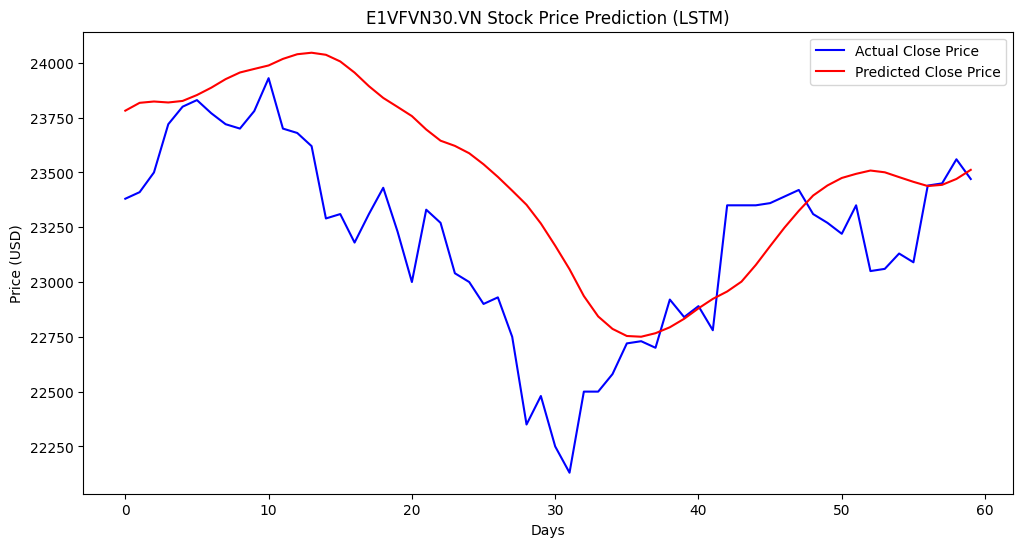

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(actuals_rescaled, label="Actual Close Price", color="blue")
plt.plot(preds_rescaled, label="Predicted Close Price", color="red")
plt.legend()
plt.title(f"{ticker} Stock Price Prediction (LSTM)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.show()